In [1]:
# 1. Install Dependencies
!pip install nixtla tensorflow pandas numpy scikit-learn

# Import Libraries
import pandas as pd
import numpy as np
from nixtla import NixtlaClient
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, Model
from google.colab import files
import warnings
warnings.filterwarnings('ignore')  # Ignore minor warnings for clarity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00


In [2]:
# 2. Data Preparation
print("Upload your dataset (e.g., temperature.csv from Kaggle)")
uploaded = files.upload()  # Upload the IoT Temperature Forecasting dataset
data = pd.read_csv(list(uploaded.keys())[0])  # Load uploaded file

Upload your dataset (e.g., temperature.csv from Kaggle)


Saving IOT-temp.csv to IOT-temp.csv


In [5]:
## Basic cleaning
print("\n=== Data Preprocessing ===")
print(f"Original data shape: {data.shape}")

# Handle missing values
missing_before = data.isnull().sum().sum()
print(f"Missing values before: {missing_before}")
data.fillna(method='ffill', inplace=True)  # Fill missing values with previous values
data.fillna(method='bfill', inplace=True)  # Fill any remaining missing values with next values
missing_after = data.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])  # Convert to datetime
print("Successfully converted 'timestamp' to datetime format")

# Set timestamp as index
data.set_index('timestamp', inplace=True)

# Detect and handle outliers
Q1 = data['temperature'].quantile(0.25)
Q3 = data['temperature'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_count = ((data['temperature'] < lower_bound) | (data['temperature'] > upper_bound)).sum()
print(f"Detected {outliers_count} outliers in temperature data")

# Cap outliers instead of removing them
data['temperature'] = data['temperature'].clip(lower=lower_bound, upper=upper_bound)
print(f"Capped temperature values between {lower_bound:.2f} and {upper_bound:.2f}")


=== Data Preprocessing ===
Original data shape: (97606, 5)
Missing values before: 0
Missing values after: 0


KeyError: 'timestamp'

In [7]:
# Define the correct column names from your dataset
time_col = 'noted_date'  # The timestamp column in your dataset
temp_col = 'temp'        # The temperature column in your dataset

# Rename columns for consistency in our pipeline
data = data.rename(columns={time_col: 'timestamp', temp_col: 'temperature'})

# Basic cleaning
print("\n=== Data Preprocessing ===")
print(f"Original data shape: {data.shape}")

# Handle missing values
missing_before = data.isnull().sum().sum()
print(f"Missing values before: {missing_before}")
data.fillna(method='ffill', inplace=True)  # Fill missing values with previous values
data.fillna(method='bfill', inplace=True)  # Fill any remaining missing values with next values
missing_after = data.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

# Convert timestamp to datetime - note that the format appears to be DD-MM-YYYY HH:MM
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%d-%m-%Y %H:%M')
print("Successfully converted 'timestamp' to datetime format")

# Set timestamp as index
data.set_index('timestamp', inplace=True)

# Detect and handle outliers
Q1 = data['temperature'].quantile(0.25)
Q3 = data['temperature'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_count = ((data['temperature'] < lower_bound) | (data['temperature'] > upper_bound)).sum()
print(f"Detected {outliers_count} outliers in temperature data")

# Cap outliers instead of removing them
data['temperature'] = data['temperature'].clip(lower=lower_bound, upper=upper_bound)
print(f"Capped temperature values between {lower_bound:.2f} and {upper_bound:.2f}")


=== Data Preprocessing ===
Original data shape: (97606, 5)
Missing values before: 0
Missing values after: 0
Successfully converted 'timestamp' to datetime format
Detected 0 outliers in temperature data
Capped temperature values between 15.00 and 55.00


In [10]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

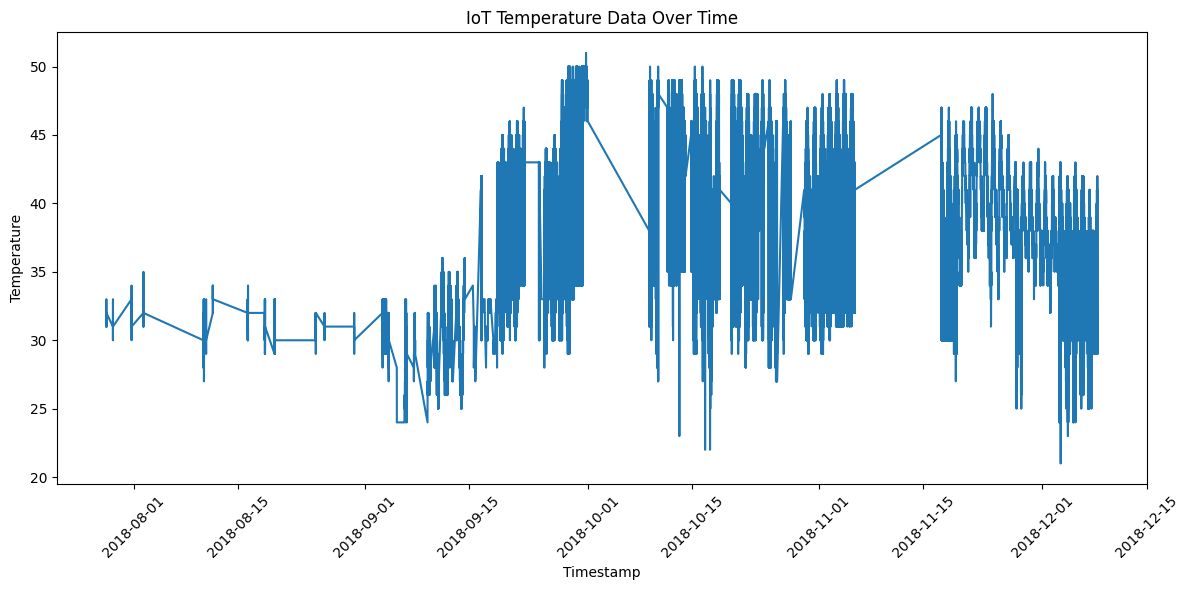

In [11]:
# Visualize temperature data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temperature'])
plt.title('IoT Temperature Data Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

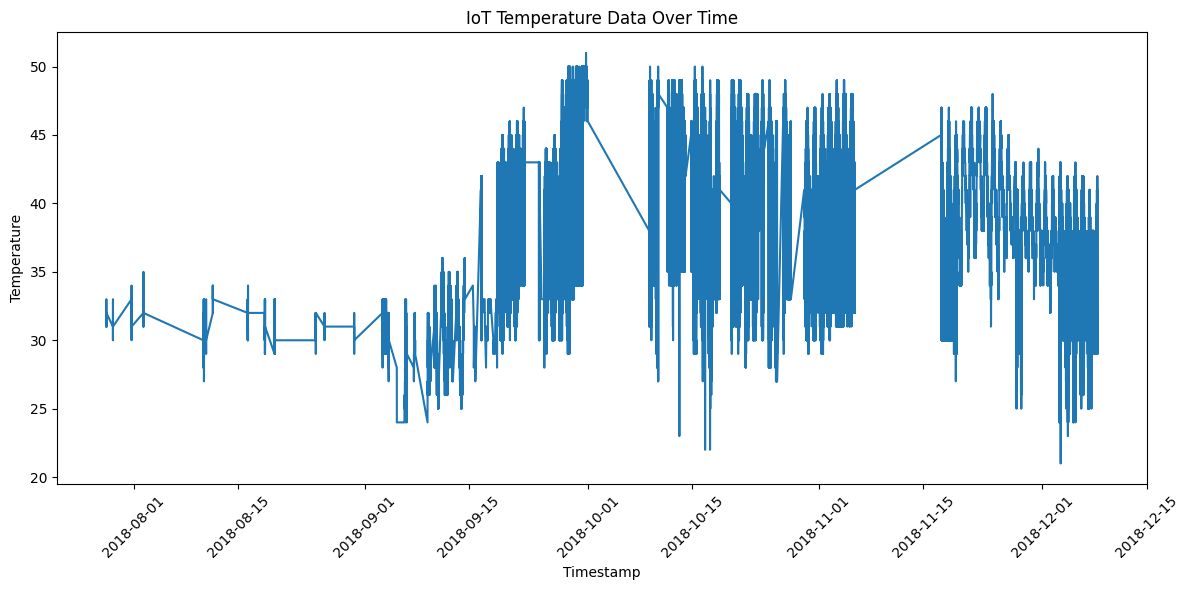


=== Train/Test Split ===
Train shape: (78084, 4) (2018-09-10 14:27:00 to 2018-12-08 09:30:00)
Test shape: (19522, 4) (2018-07-28 07:06:00 to 2018-09-10 14:27:00)


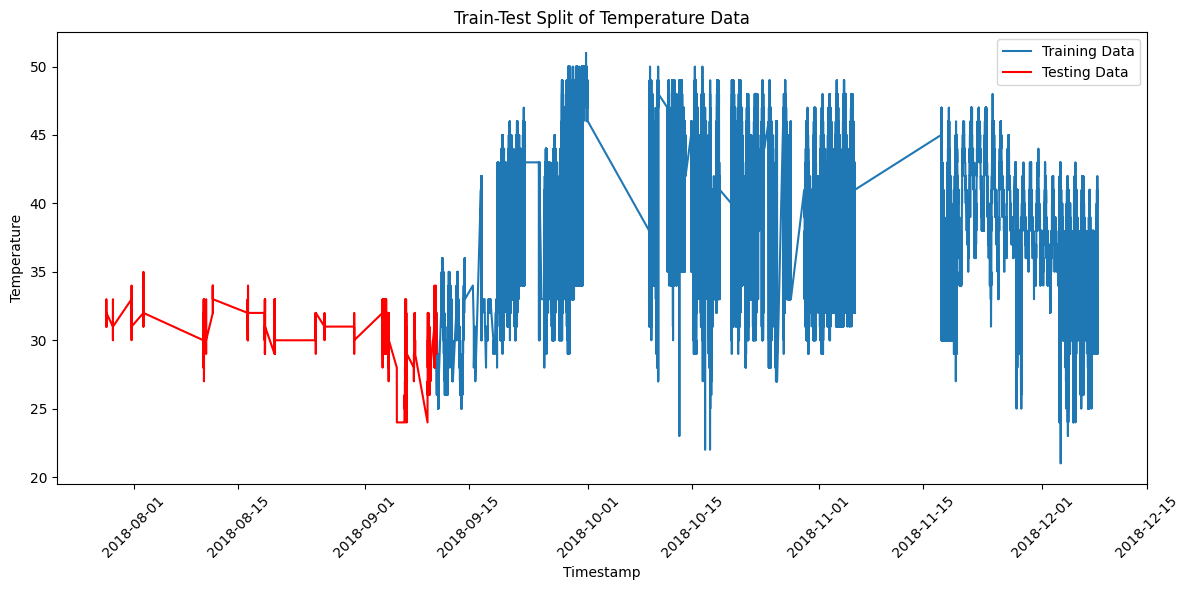

In [12]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize temperature data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temperature'])
plt.title('IoT Temperature Data Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Split into train (80%) and test (20%)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]
print("\n=== Train/Test Split ===")
print(f"Train shape: {train.shape} ({train.index.min()} to {train.index.max()})")
print(f"Test shape: {test.shape} ({test.index.min()} to {test.index.max()})")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['temperature'], label='Training Data')
plt.plot(test.index, test['temperature'], label='Testing Data', color='red')
plt.title('Train-Test Split of Temperature Data')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== Feature Engineering ===
Added 'hour' feature to capture daily temperature cycles
Added 'dayofweek' feature to capture weekly patterns
Added 'prev_temp' feature (lag-1) to incorporate recent temperature history
Added 'temp_ma' feature (24-hour moving average) to capture trends

Feature correlation with temperature:
temperature    1.000000
temp_ma        0.878495
prev_temp      0.791821
dayofweek      0.345341
hour          -0.036869
Name: temperature, dtype: float64


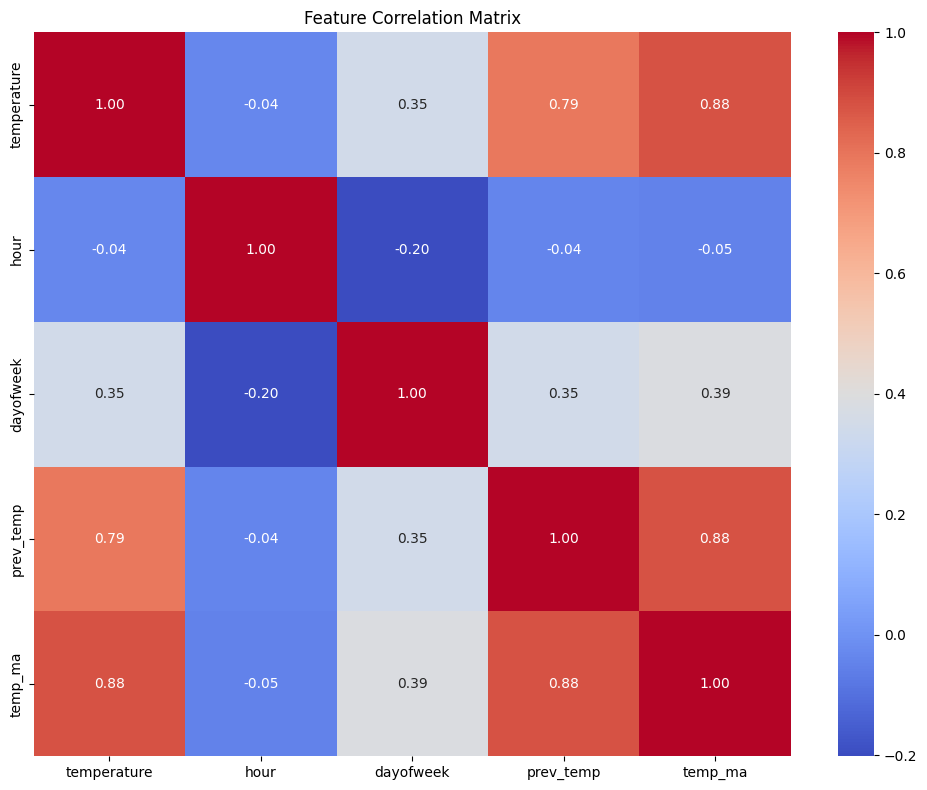

In [13]:
# Feature Engineering
print("\n=== Feature Engineering ===")

# Feature 1: Hour of day (captures daily temperature cycles)
train['hour'] = train.index.hour
test['hour'] = test.index.hour
print("Added 'hour' feature to capture daily temperature cycles")

# Feature 2: Day of week (captures weekly patterns)
train['dayofweek'] = train.index.dayofweek
test['dayofweek'] = test.index.dayofweek
print("Added 'dayofweek' feature to capture weekly patterns")

# Feature 3: Previous temperature (lag-1)
train['prev_temp'] = train['temperature'].shift(1)
train.fillna(method='bfill', inplace=True)  # Fill NaN from shift
test['prev_temp'] = test['temperature'].shift(1)
test.fillna(method='bfill', inplace=True)
print("Added 'prev_temp' feature (lag-1) to incorporate recent temperature history")

# Feature 4: Temperature moving average (captures trends)
window_size = 24  # 24-hour window
train['temp_ma'] = train['temperature'].rolling(window=window_size, min_periods=1).mean()
test['temp_ma'] = test['temperature'].rolling(window=window_size, min_periods=1).mean()
print(f"Added 'temp_ma' feature ({window_size}-hour moving average) to capture trends")

# Feature significance analysis
correlation = train[['temperature', 'hour', 'dayofweek', 'prev_temp', 'temp_ma']].corr()
print("\nFeature correlation with temperature:")
print(correlation['temperature'].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


=== Model Training (Random Forest) ===
Training Random Forest model...
Model training completed!

Feature Importance:
     Feature  Importance
3    temp_ma    0.860368
0       hour    0.055877
2  prev_temp    0.052836
1  dayofweek    0.030919


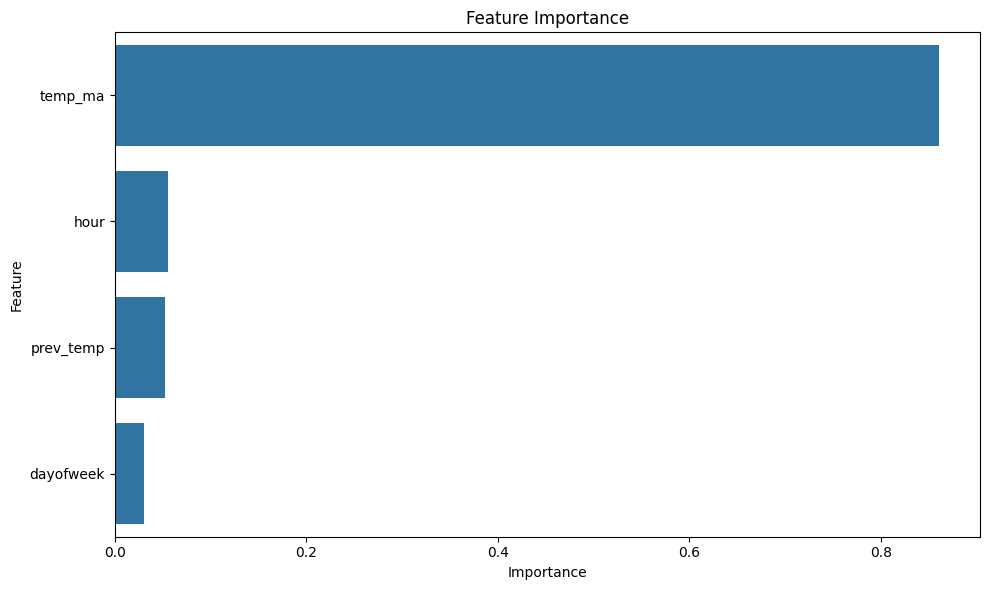


=== Model Evaluation ===
Mean Absolute Error (MAE): 0.7314
Mean Squared Error (MSE): 0.9741
Root Mean Squared Error (RMSE): 0.9870
Mean Absolute Percentage Error (MAPE): 2.45%
Mean Absolute Scaled Error (MASE): 0.2939
Note: MASE < 1 indicates the model outperforms a naive forecast


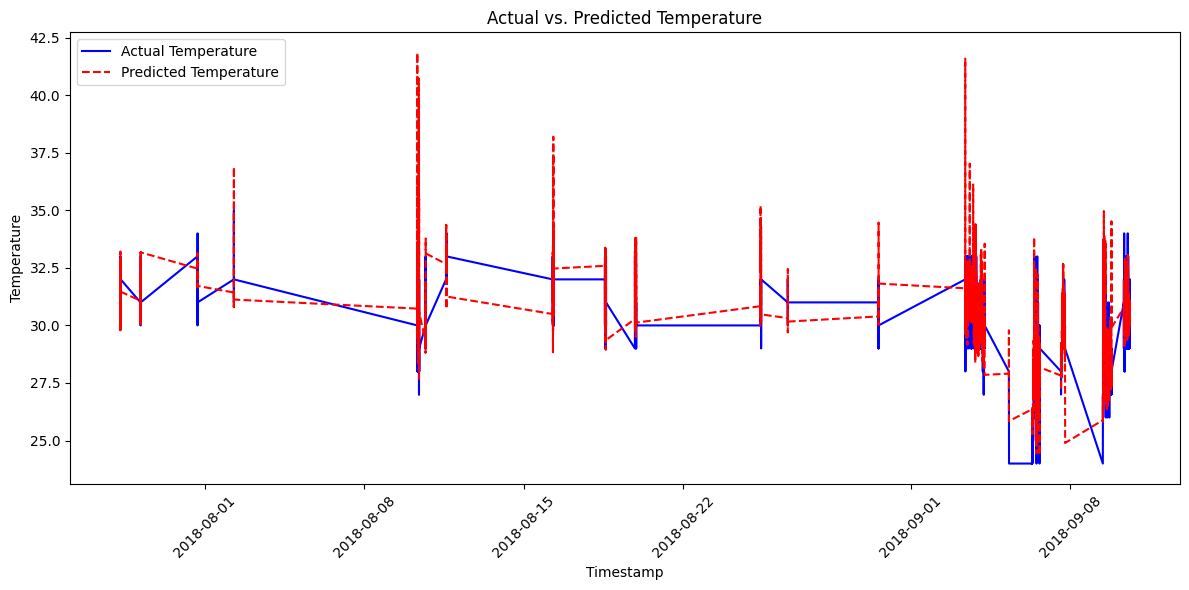

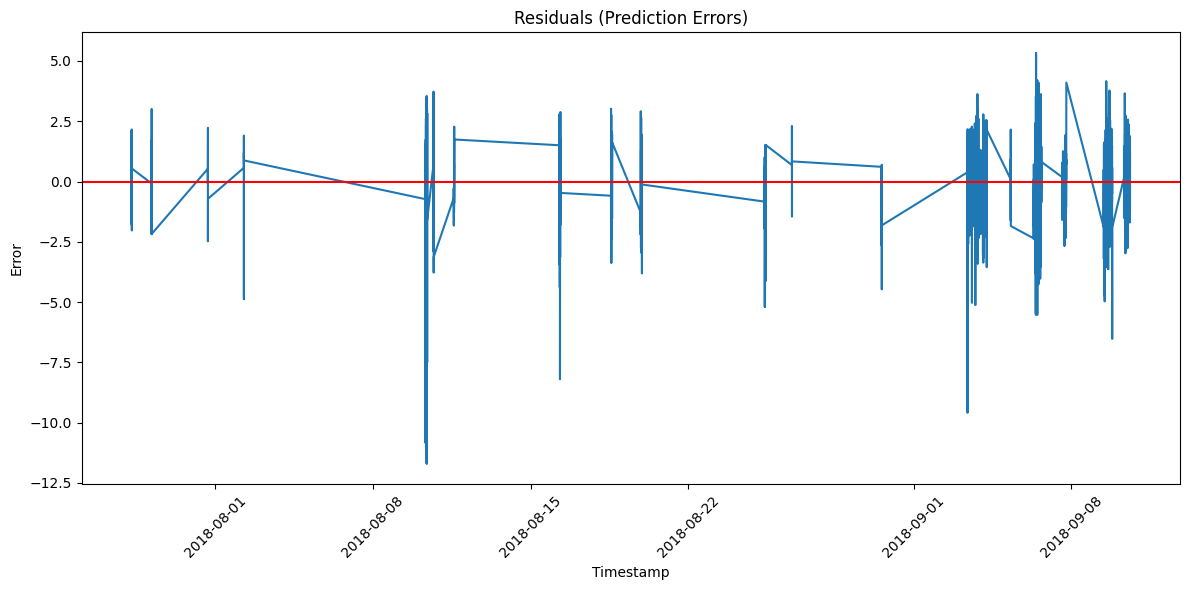

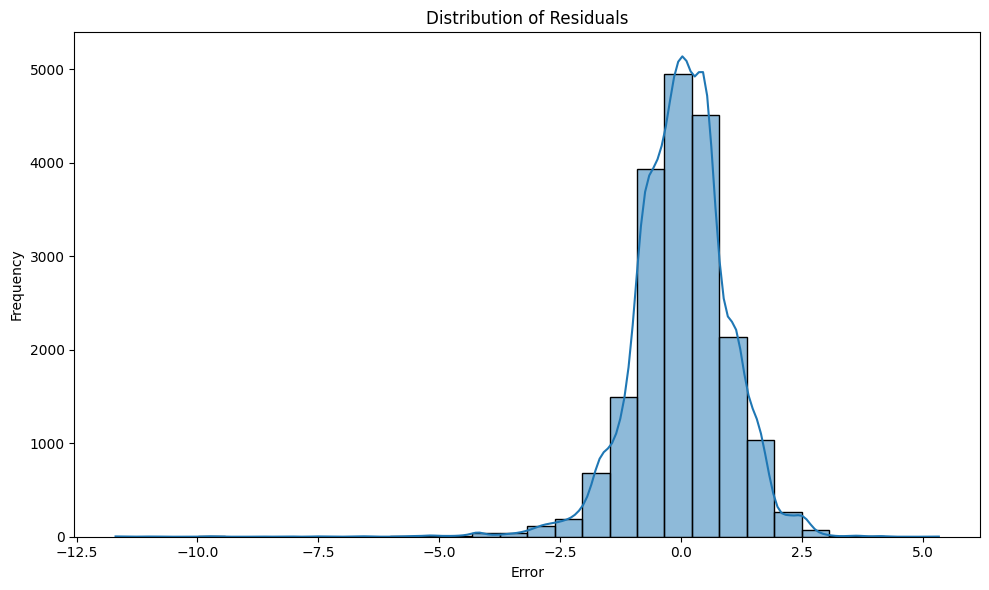

In [15]:
# Import additional libraries for forecasting
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

print("\n=== Model Training (Random Forest) ===")

# Make sure y_test is defined
X_train = train[['hour', 'dayofweek', 'prev_temp', 'temp_ma']]
y_train = train['temperature']

X_test = test[['hour', 'dayofweek', 'prev_temp', 'temp_ma']]
y_test = test['temperature']  # This is the missing definition

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
print("Training Random Forest model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
print("Model training completed!")

# Make predictions
predicted = model.predict(X_test_scaled)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Model Evaluation
print("\n=== Model Evaluation ===")

# Calculate metrics
actual = y_test.values
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Calculate MASE
naive_forecast = train['temperature'].iloc[-len(test):].values
naive_mae = mean_absolute_error(actual, naive_forecast)
mase = mae / naive_mae
print(f"Mean Absolute Scaled Error (MASE): {mase:.4f}")
print(f"Note: MASE < 1 indicates the model outperforms a naive forecast")

# Visualize actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, actual, label='Actual Temperature', color='blue')
plt.plot(test.index, predicted, label='Predicted Temperature', color='red', linestyle='--')
plt.title('Actual vs. Predicted Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residual analysis
residuals = actual - predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals (Prediction Errors)')
plt.xlabel('Timestamp')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [16]:
# Rolling-Origin Cross-Validation
print("\n=== Rolling-Origin Cross-Validation ===")
from sklearn.model_selection import TimeSeriesSplit

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)
validation_maes = []

# Convert to numpy arrays for splitting
X_train_array = X_train_scaled
y_train_array = y_train.values

for i, (train_index, test_index) in enumerate(tscv.split(X_train_array)):
    # Get the training and validation sets
    X_train_cv, X_val_cv = X_train_array[train_index], X_train_array[test_index]
    y_train_cv, y_val_cv = y_train_array[train_index], y_train_array[test_index]

    # Train the model
    model_cv = RandomForestRegressor(n_estimators=100, random_state=42)
    model_cv.fit(X_train_cv, y_train_cv)

    # Make predictions
    y_pred_cv = model_cv.predict(X_val_cv)

    # Calculate MAE
    mae_cv = mean_absolute_error(y_val_cv, y_pred_cv)
    validation_maes.append(mae_cv)
    print(f"Cross-validation fold {i+1}: MAE = {mae_cv:.4f} (validation size: {len(y_val_cv)})")

avg_cv_mae = np.mean(validation_maes)
cv_mae_std = np.std(validation_maes)
print(f"Average cross-validation MAE: {avg_cv_mae:.4f} ± {cv_mae_std:.4f}")


=== Rolling-Origin Cross-Validation ===
Cross-validation fold 1: MAE = 0.9124 (validation size: 19521)
Cross-validation fold 2: MAE = 2.1626 (validation size: 19521)
Cross-validation fold 3: MAE = 1.2684 (validation size: 19521)
Average cross-validation MAE: 1.4478 ± 0.5259



Generating 1000 synthetic temperature records...
Using hourly frequency for synthetic data timestamps


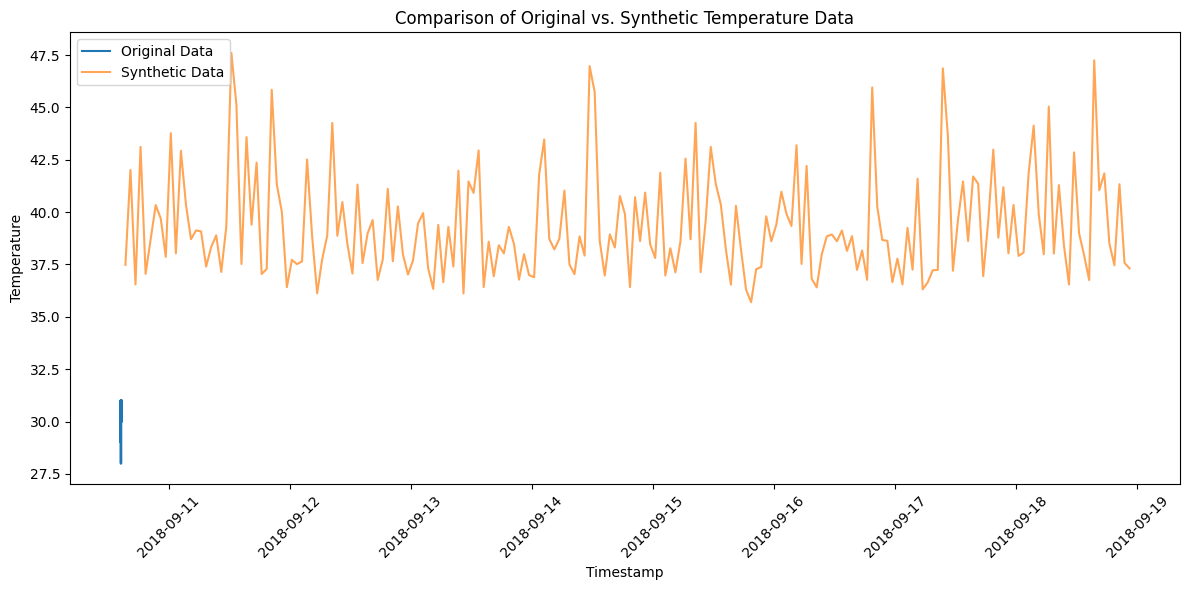

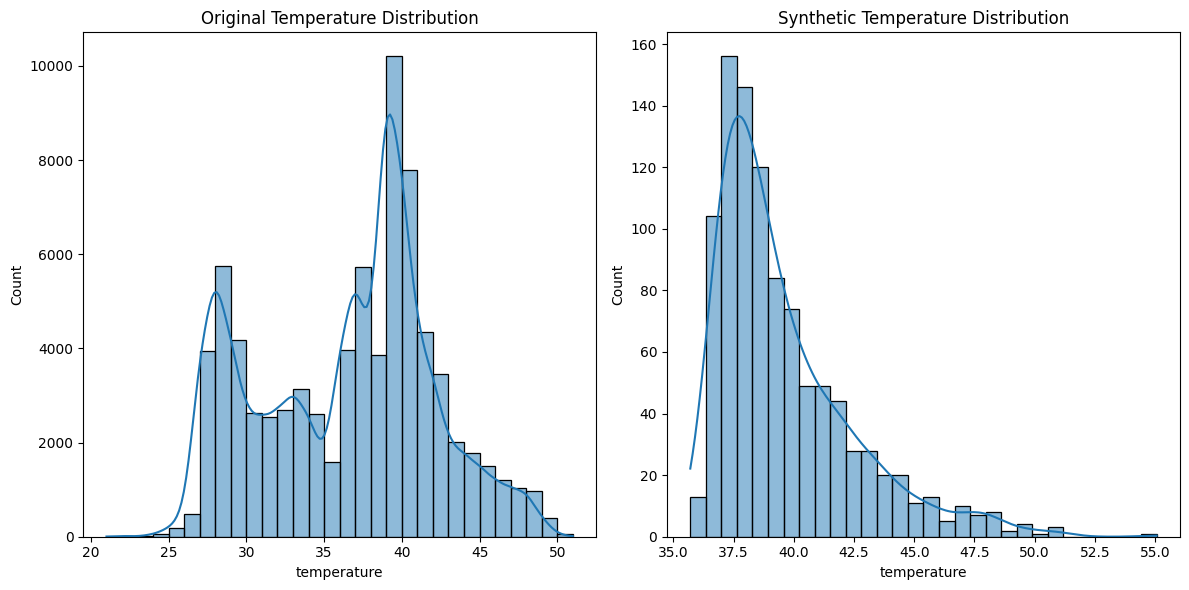

In [19]:
## Generate synthetic data
n_synthetic = 1000  # Number of synthetic samples
print(f"\nGenerating {n_synthetic} synthetic temperature records...")

# Sample from latent space
z_sample = np.random.normal(size=(n_synthetic, latent_dim))
synthetic_temp = decoder.predict(z_sample, verbose=0)

# Un-normalize
synthetic_temp = synthetic_temp * temp_std + temp_mean

# Create timestamps for synthetic data (continuing from train end)
# Fix the frequency issue - use a fixed hourly frequency
print("Using hourly frequency for synthetic data timestamps")
synthetic_timestamps = pd.date_range(
    start=train.index[-1] + pd.Timedelta(hours=1),  # Add 1 hour explicitly
    periods=n_synthetic,
    freq='H'  # Use hourly frequency
)

# Create synthetic dataframe with all features
synthetic_df = pd.DataFrame({
    'timestamp': synthetic_timestamps,
    'temperature': synthetic_temp.flatten()
})
synthetic_df.set_index('timestamp', inplace=True)

# Add the same features as original data
synthetic_df['hour'] = synthetic_df.index.hour
synthetic_df['dayofweek'] = synthetic_df.index.dayofweek
synthetic_df['prev_temp'] = synthetic_df['temperature'].shift(1)
synthetic_df.fillna(method='bfill', inplace=True)
synthetic_df['temp_ma'] = synthetic_df['temperature'].rolling(window=24, min_periods=1).mean()

# Visualize synthetic vs. original data
plt.figure(figsize=(12, 6))
plt.plot(train.index[-200:], train['temperature'][-200:], label='Original Data')
plt.plot(synthetic_df.index[:200], synthetic_df['temperature'][:200], label='Synthetic Data', alpha=0.7)
plt.title('Comparison of Original vs. Synthetic Temperature Data')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compare distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['temperature'], bins=30, kde=True)
plt.title('Original Temperature Distribution')
plt.subplot(1, 2, 2)
sns.histplot(synthetic_df['temperature'], bins=30, kde=True)
plt.title('Synthetic Temperature Distribution')
plt.tight_layout()
plt.show()

Original training set size: 78084
Synthetic data size: 1000
Augmented training set size: 79084

=== Re-training with Augmented Dataset ===
Augmented model training completed!

=== Augmented Model Evaluation ===
Augmented MAE: 0.7294 (Original: 0.7314)
Augmented MSE: 0.9715 (Original: 0.9741)
Augmented RMSE: 0.9856 (Original: 0.9870)
Augmented MAPE: 2.44% (Original: 2.45%)
Augmented MASE: 0.2931 (Original: 0.2939)

Improvement in MAE: 0.28%


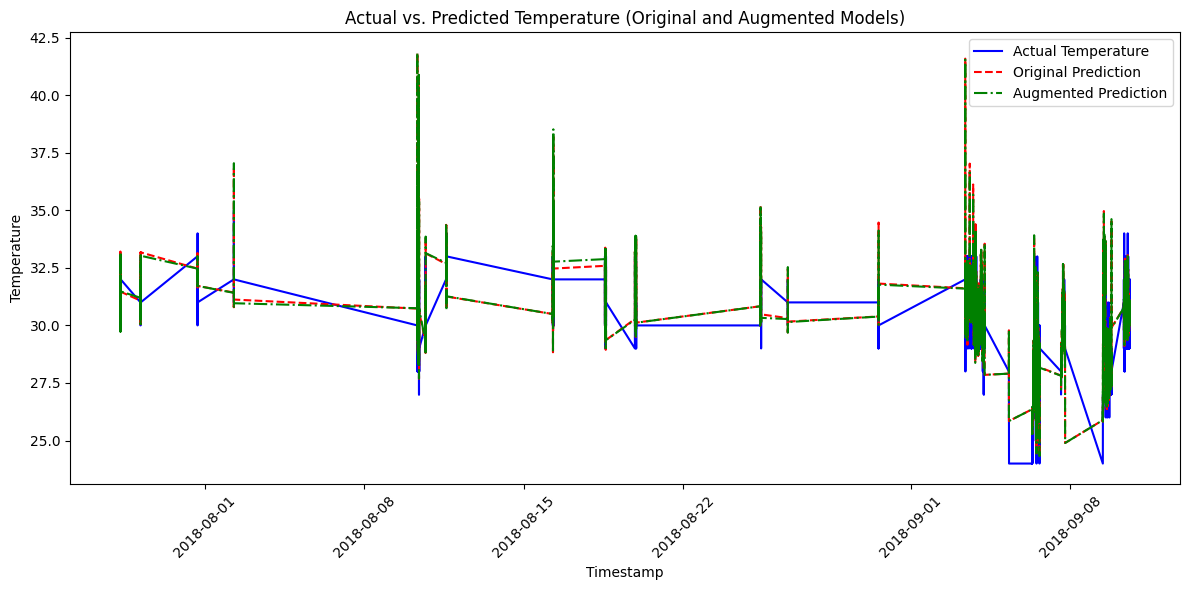


=== Final Results for Report ===
Original Model:
MAE: 0.7314
MSE: 0.9741
RMSE: 0.9870
MAPE: 2.45%
MASE: 0.2939
Cross-validation MAE: 1.4478

Augmented Model:
MAE: 0.7294
MSE: 0.9715
RMSE: 0.9856
MAPE: 2.44%
MASE: 0.2931
Improvement: 0.28%


In [21]:
# Augment training data with synthetic data
augmented_train = pd.concat([train, synthetic_df])
print(f"Original training set size: {len(train)}")
print(f"Synthetic data size: {len(synthetic_df)}")
print(f"Augmented training set size: {len(augmented_train)}")

# Prepare the augmented features and target
X_augmented = augmented_train[['hour', 'dayofweek', 'prev_temp', 'temp_ma']]
y_augmented = augmented_train['temperature']

# Scale features
X_augmented_scaled = scaler.transform(X_augmented)

# Re-train the model with augmented data
print("\n=== Re-training with Augmented Dataset ===")
model_aug = RandomForestRegressor(n_estimators=100, random_state=42)
model_aug.fit(X_augmented_scaled, y_augmented)
print("Augmented model training completed!")

# Make predictions with augmented model
predicted_aug = model_aug.predict(X_test_scaled)

# Evaluate augmented model
mae_aug = mean_absolute_error(actual, predicted_aug)
mse_aug = mean_squared_error(actual, predicted_aug)
rmse_aug = np.sqrt(mse_aug)
mape_aug = np.mean(np.abs((actual - predicted_aug) / actual)) * 100

# Calculate MASE for augmented model
mase_aug = mae_aug / naive_mae

print("\n=== Augmented Model Evaluation ===")
print(f"Augmented MAE: {mae_aug:.4f} (Original: {mae:.4f})")
print(f"Augmented MSE: {mse_aug:.4f} (Original: {mse:.4f})")
print(f"Augmented RMSE: {rmse_aug:.4f} (Original: {rmse:.4f})")
print(f"Augmented MAPE: {mape_aug:.2f}% (Original: {mape:.2f}%)")
print(f"Augmented MASE: {mase_aug:.4f} (Original: {mase:.4f})")

improvement_mae = ((mae - mae_aug) / mae) * 100
print(f"\nImprovement in MAE: {improvement_mae:.2f}%")

# Visualize original vs. augmented predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, actual, label='Actual Temperature', color='blue')
plt.plot(test.index, predicted, label='Original Prediction', color='red', linestyle='--')
plt.plot(test.index, predicted_aug, label='Augmented Prediction', color='green', linestyle='-.')
plt.title('Actual vs. Predicted Temperature (Original and Augmented Models)')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Simple results printing for report
print("\n=== Final Results for Report ===")
print("Original Model:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MASE: {mase:.4f}")
print(f"Cross-validation MAE: {avg_cv_mae:.4f}")

print("\nAugmented Model:")
print(f"MAE: {mae_aug:.4f}")
print(f"MSE: {mse_aug:.4f}")
print(f"RMSE: {rmse_aug:.4f}")
print(f"MAPE: {mape_aug:.2f}%")
print(f"MASE: {mase_aug:.4f}")
print(f"Improvement: {improvement_mae:.2f}%")